# KITTI Odometry Dataset - Computer Vision
This notebook uses OpenCV to apply stereo depth estimation and multi-view geometry to attempt to track vehicle position through a sequence of the KITTI odometry dataset. A dataset handler class is provided to easily interact with the provided data and sensor calibration information. Useful functions are also provided to perform this basic example of visual odometry using the opencv-python package. This notebook pairs with a [series of video tutorials on YouTube](https://www.youtube.com/playlist?list=PLrHDCRerOaI9HfgZDbiEncG5dx7S3Nz6X).

While exploring this dataset, this notebook will review fundamental computer vision principles required to perform the task of stereo depth estimation and visual odometry, and demonstrate the implementation of those principles using numpy and OpenCV in Python. 

These topics will include: 
 - The pinhole camera model 
 - Intrinsic and extrinsic camera parameters and matrices
 - Projection matrices
 - Rectified projection matrices
 - Projective geometry
 - 3D tranformations
 - Disparity and depth estimation from stereo
 - Image Feature detection/description/matching
 - Pose estimation from Perspective n Point (PnP) algorithm using RANSAC
 
In this way, the author hopes that it will serve as a useful source of knowledge and intuition for intermediate Python programmers who are beginning to explore computer vision and/or autonomous vehicle research.

The notebook assumes that this repository is placed in a folder alongside another folder which contains your download of the KITTI odometry dataset. If you have your data downloaded in a separate folder, adjust the file paths accordingly. The ground truth poses are based on the left grayscale camera, so we will be using the grayscale stereo pair, and there is no need to download the sizeable RGB portion of the dataset to follow this tutorial.

The only packages required to run the notebook are basic python packages and OpenCV. The dataset handler class uses progressbar2 for fashion, but if you don't have or want that module, simply pass progress_bar=False when instantiating the Dataset_Handler class to avoid error.

Because storing the sequences as lists attached to the Dataset_Handler class takes around 20GB of RAM, there is a boolean argument low_memory, which if passed as 'True' will create a class with generators rather than lists, so that the memory use is manageable. This is the default behavior. If you have a lot of RAM, pass 'False'.

In [511]:
import cv2
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd


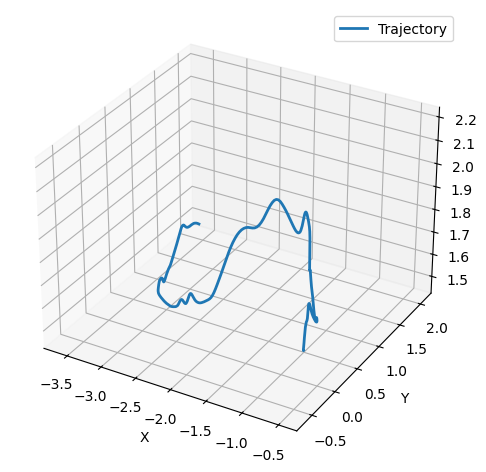

In [512]:

# Load CSV
df = pd.read_csv("/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/poses.csv")

# Number of points to plot
subset = 400

# Extract first 'subset' rows for x, y, z
x = df['x'].iloc[:subset]
y = df['y'].iloc[:subset]
z = df['z'].iloc[:subset]

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Trajectory', linewidth=2)

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import yaml

def load_euroc_camera(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    intrinsics = data['intrinsics']
    T_BS = np.array(data['T_BS']['data']).reshape(4, 4)
    return intrinsics, T_BS


def write_kitti_format(P0, P1, output_path="calib.txt"):
    with open(output_path, 'w') as f:
        #f.write("# Converted from EuRoC YAML to KITTI format\n")
        #f.write("calib_time: generated_by_script\n\n")

        f.write("P0: " + " ".join([f"{v:.12e}" for v in P0.flatten()]) + "\n")
        f.write("P1: " + " ".join([f"{v:.12e}" for v in P1.flatten()]) + "\n")

    print(f"\nKITTI-style calibration saved to: {output_path}")

def compute_baseline(T0, T1):
    # Compute x-axis translation between two cameras
    t0 = T0[:3, 3]
    t1 = T1[:3, 3]
    baseline = abs(t1[0] - t0[0])
    return baseline

def build_projection_matrix(intrinsics, Tx=0.0):
    fu, fv, cu, cv = intrinsics
    P = np.array([
        [fu, 0,  cu, Tx],
        [0,  fv, cv, 0],
        [0,   0,  1,  0]
    ])
    return P

def main():
    cam0_path = '/home/ros_ws/noetic/data/V1_01_easy/mav0/cam0/sensor.yaml'
    cam1_path = '/home/ros_ws/noetic/data/V1_01_easy/mav0/cam1/sensor.yaml'

    intr0, T0 = load_euroc_camera(cam0_path)
    intr1, T1 = load_euroc_camera(cam1_path)

    baseline = compute_baseline(T0, T1)

    # Tx = -fu * baseline
    Tx = -intr0[0] * baseline

    P0 = build_projection_matrix(intr0)
    P1 = build_projection_matrix(intr1, Tx=Tx)

    print("\nP0:")
    print(P0)
    print("\nP1:")
    print(P1)

    write_kitti_format(P0, P1)

main()


Now let's take a quick look at our first image.

In [514]:
test_img = cv2.imread(f'/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/images/000000.png')

In [515]:
type(test_img)

numpy.ndarray

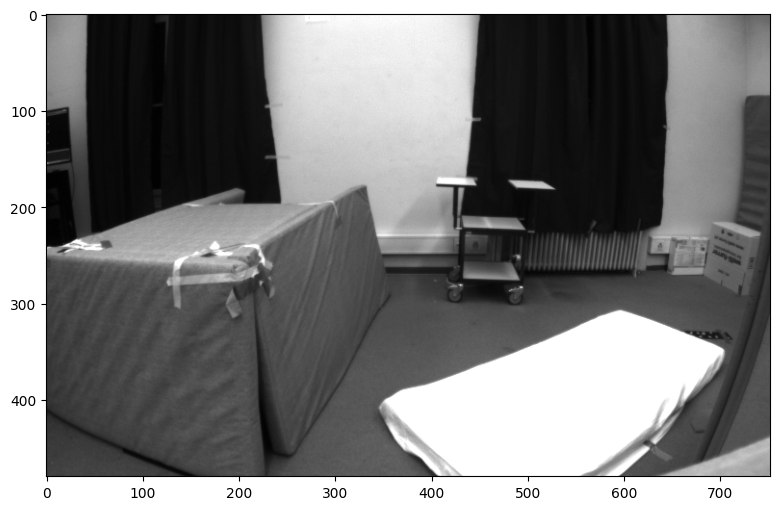

In [516]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_img)

## Data Exploration

In [517]:
# We can use the listdir() function to get a list of filenames in a folder
left_image_files = os.listdir(f'/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/images')
left_image_files[:5]

['000505.png', '002147.png', '000919.png', '001403.png', '001938.png']

In [518]:
# We can use this list to count the number of images in the sequence
len(left_image_files)

2276

In [519]:
# Now we can check if this matches the number of ground truth poses
len(x)

400

In [520]:
# We can see they match perfectly. Our first ground truth pose is (0, 0, 0), so we
# are tracking the motion of the camera with respect to the first camera frame.

### Projection Matrices - Sensor Calibration

In [521]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,458.654,0.0,367.215,0.000000,0.0,457.296,248.375,0.0,0.0,0.0,1.0,0.0
P1:,459.587,0.0,379.999,-0.824012,0.0,456.134,255.238,0.0,0.0,0.0,1.0,0.0


In [522]:
# P0 is the projection matrix left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[458.654,   0.   , 367.215,   0.   ],
       [  0.   , 457.296, 248.375,   0.   ],
       [  0.   ,   0.   ,   1.   ,   0.   ]])

In [523]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[459.587   0.    379.999]
 [  0.    456.134 255.238]
 [  0.      0.      1.   ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[0.0018]
 [0.    ]
 [0.    ]
 [1.    ]]


In [524]:
# Above, we can see the intrinsic matrix k, the rotation matrix R, and the translation vector
# t we got by decomposing the projection matrix given for the right camera. Remember that
# the extrinsic matrix is actually a horizontal stack of R and t in the form (R|t), which
# we can use to transform a 3D homogenous coordinate in the global frame to a 3D coordinate
# in the camera frame, at least if this were a normal camera projection matrix.
# In this case, let's see what we get if we transform the origin of the global coordinate
# frame (the origin of the left grayscale camera) using the tranformation/extrinsic matrix
# we got from this projection matrix. According to the schematic, we should expect it to be
# 0.54m to the left (X = -0.54)
# Note that the OpenCV function has provided t as a homogeneous coordinate, so we need to
# drop the fourth value to horizontally stack it with the 3x3 rotation matrix.
Rt = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
origin = np.array([0, 0, 0, 1])
Rt.dot(origin).round(4).reshape(-1,1)

array([[0.0018],
       [0.    ],
       [0.    ]])

Each rectified projection matrix will take (X, Y, Z, 1) homogeneous coordinates of 3D points in the associated sensor's coordinate frame and translates them to pixel locations (u, v, 1) on the image plane of the left grayscale camera.

Notice that the result we got from translating the origin is identical to the translation vector itself, so it is not necessary to do the extra step of math to figure out where the origin of the "global" coordinate frame is in relation to a camera, one only has to look at t. In this case, we can see that the rectified projection matrix decomposes into an extrinsic matrix which tells us that the "global" coordinate frame origin of the right camera is 0.54m to the right of the left camera, which matches what we see in the schematic.

In [525]:
# As an exercise, let's turn this rectified projection matrix into a regular projection matrix
# for the right grayscale camera. We do this by decomposing the matrix, making the extrinsic
# matrix homogeneous, inverting it, then recombining the intrinsic and inverted extrinsic.
# Since we've already decomposed and stacked the Rt transformation matrix, let's now make
# it homogeneous and run our test to see if the origin of the left camera appears at X=-0.54
T_homogeneous = np.vstack([Rt, np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
print('Homogeneous transformation matrix:')
print(T_homogeneous.round(4))
print('Inverted homogeneous transformation matrix:')
print(T_hom_inv.round(4))

Homogeneous transformation matrix:
[[1.     0.     0.     0.0018]
 [0.     1.     0.     0.    ]
 [0.     0.     1.     0.    ]
 [0.     0.     0.     1.    ]]
Inverted homogeneous transformation matrix:
[[ 1.      0.      0.     -0.0018]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [526]:
# Let's compare the optical center to the size of the image (expect it to be halfway?)
test_img.shape

(480, 752, 3)

In [527]:
cx = k1[0,2]
cy = k1[1,2]
print('Actual center of image (x, y):', (test_img.shape[1]/2, test_img.shape[0]/2))
print('Optical center of image (cx, cy)', (cx, cy))

Actual center of image (x, y): (376.0, 240.0)
Optical center of image (cx, cy) (np.float64(379.999), np.float64(255.238))


To finish up our data exploration, let's look at the other two camera matrices included in our calibration file, which refer to the RGB cameras in the rig.

### Dataset Handling
Let's make a dataset handling object to make our data more accessible as we complete our task.

In [528]:
import os
import cv2
import numpy as np
import pandas as pd

class Dataset_Handler():
    def __init__(self, subset=None, progress_bar=False):
        # Set file paths
        self.seq_dir_0 = '/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/images/'
        self.seq_dir_1 = '/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam1_easy_q_rpy/images/'
        self.poses_dir = '/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/poses.csv'
        self.calib_dir = 'calib.txt'

        # Load poses
        self.poses = pd.read_csv(self.poses_dir, delimiter=',', header=None)

        # Get sorted filenames
        self.left_image_files = sorted(os.listdir(self.seq_dir_0), key=lambda x: int(x.split(".")[0]))
        self.right_image_files = sorted(os.listdir(self.seq_dir_1), key=lambda x: int(x.split(".")[0]))

        # Limit number of frames by subset if provided
        if subset is not None:
            self.left_image_files = self.left_image_files[:subset]
            self.right_image_files = self.right_image_files[:subset]
        
        self.num_frames = len(self.left_image_files)

        # Load calibration
        calib = pd.read_csv(self.calib_dir, delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))

        # Load images
        if progress_bar:
            import progressbar
            bar = progressbar.ProgressBar(max_value=self.num_frames)

        self.images_left = []
        self.images_right = []
        for i, (name_left, name_right) in enumerate(zip(self.left_image_files, self.right_image_files)):
            left_img = cv2.imread(os.path.join(self.seq_dir_0, name_left))
            right_img = cv2.imread(os.path.join(self.seq_dir_1, name_right))
            self.images_left.append(left_img)
            self.images_right.append(right_img)
            if progress_bar:
                bar.update(i+1)

        # Store some common attributes
        self.imheight = self.images_left[0].shape[0]
        self.imwidth = self.images_left[0].shape[1]
        self.first_image_left = self.images_left[0]
        self.first_image_right = self.images_right[0]
        self.second_image_left = self.images_left[1]

    def reset_frames(self):
        # Reload all images as generators (lazy loading, grayscale)
        self.images_left = (cv2.imread(os.path.join(self.seq_dir_0, name), 0)
                            for name in self.left_image_files)
        self.images_right = (cv2.imread(os.path.join(self.seq_dir_1, name), 0)
                             for name in self.right_image_files)


In [529]:
# Creating a handler object
handler = Dataset_Handler(subset)

In [530]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
        
    # Ensure grayscale and uint8
    if len(img_left.shape) == 3:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    if len(img_right.shape) == 3:
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    if img_left.dtype != np.uint8:
        img_left = (img_left * 255).astype(np.uint8) if img_left.max() <= 1 else img_left.astype(np.uint8)

    if img_right.dtype != np.uint8:
        img_right = (img_right * 255).astype(np.uint8) if img_right.max() <= 1 else img_right.astype(np.uint8)


    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

In [531]:
%matplotlib inline

Time to compute disparity map using StereoBM: 0:00:00.009340


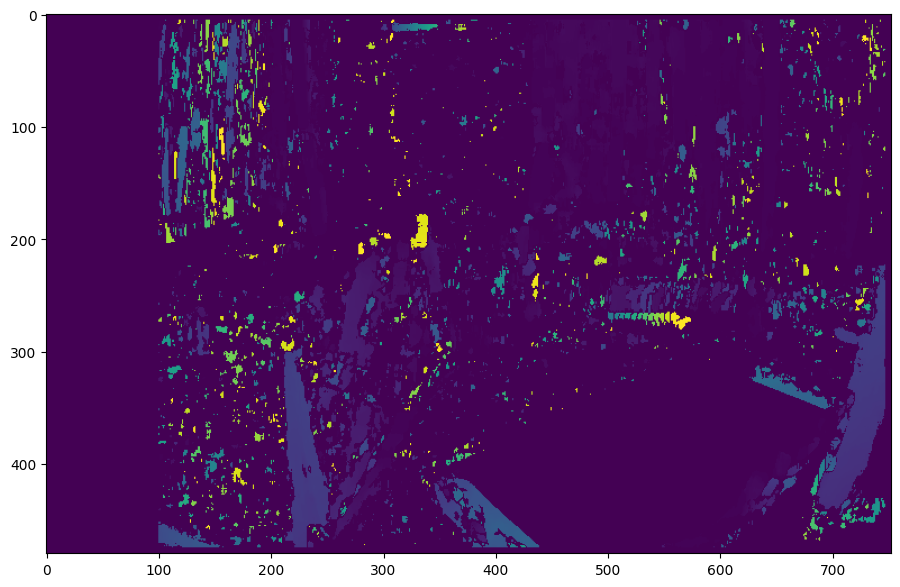

In [532]:
# Compute disparity using StereoBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

Time to compute disparity map using StereoSGBM: 0:00:00.019510


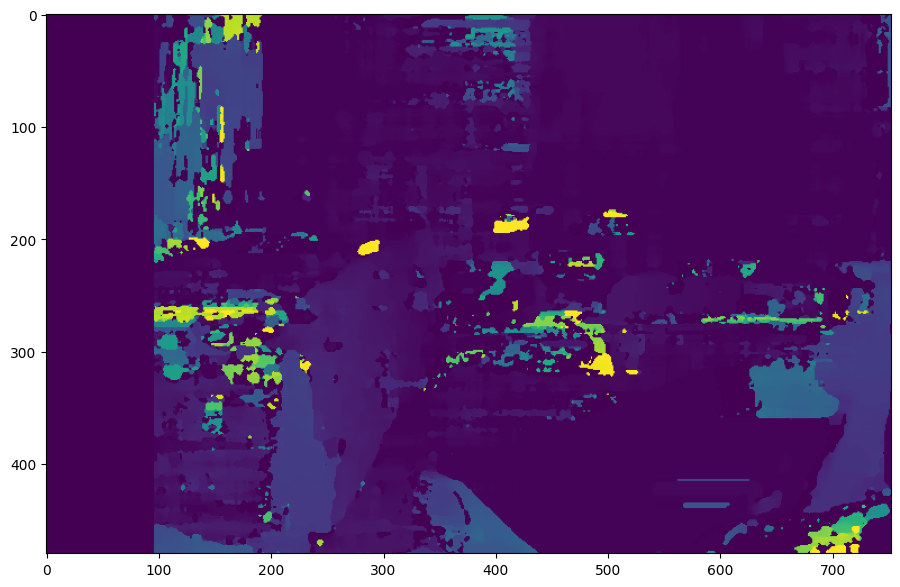

In [533]:
# Now to compare this to StereoSGBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

We can see that there is a gap of the left side of the image where the right camera did not have matching information. This means that we should apply a mask when looking for features to match from one frame to the next so that we can use features which fall in the area of the picture for which we have depth information.

In [534]:
# A look at what value the function above produces in places where it gets improper/missing data
disp[0,0]

np.float32(-1.0)

In [535]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [536]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

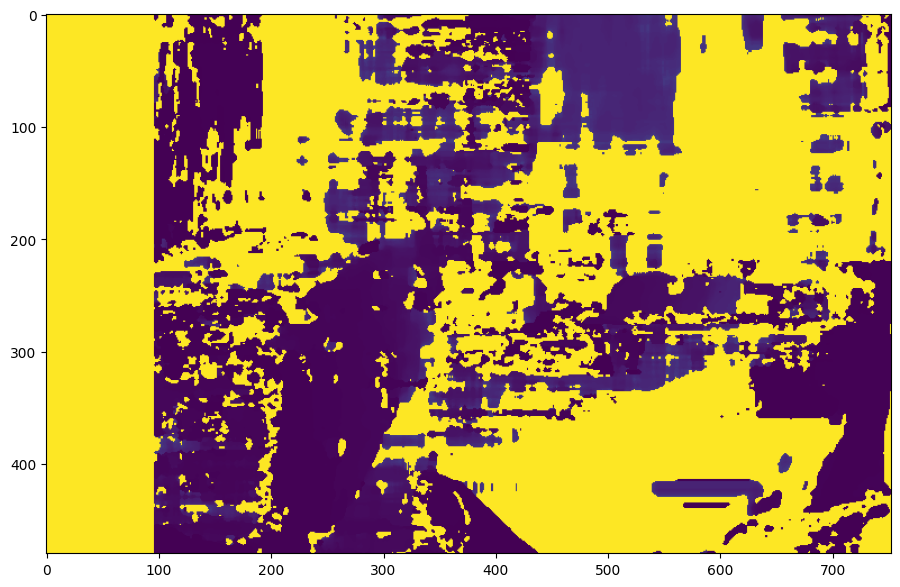

In [537]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth)

In [538]:
# Let's see what the depth is in the yellow band to the left
depth[0,0]

np.float64(8.223392368710533)

In [539]:
# Let's see if this is the same as the maximum estimated depth
depth.max()

np.float64(8.223392368710533)

In [540]:
# Knowing the focal length and baseline, we can see that these max values are the result of
# wherever we had -1.0 or 0 disparity, which we turned to 0.1 in the depth map function to
# avoid instability or division by zero, shown below:
k_left[0][0] * (t_right[0] - t_left[0]) / 0.1

array([8.22339249])

(array([138567.,  19999.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 202394.]),
 array([0.0086562 , 0.83012982, 1.65160344, 2.47307705, 3.29455067,
        4.11602429, 4.9374979 , 5.75897152, 6.58044514, 7.40191875,
        8.22339237]),
 <BarContainer object of 10 artists>)

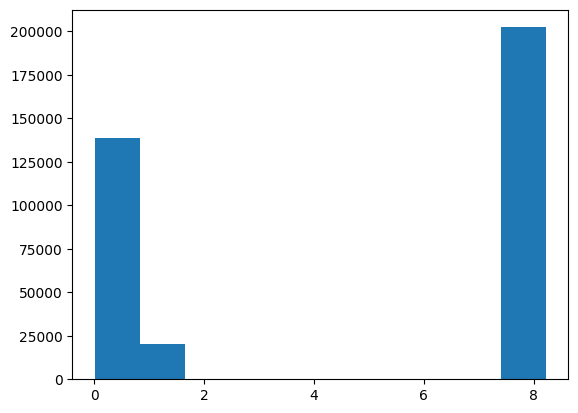

In [541]:
# We do not want any features found at this depth to enter into our calculations, since
# this is just a filler value and is not a valid estimation of depth. We need to pick a depth
# at which to filter our depth estimations.
# Let's see the distribution of depths from our depth map, so we can decide a threshold to cut
# off points of consideration so they don't mess with our geometry
plt.hist(depth.flatten())

In [542]:
# We want to find the width of the yellow band, in order to
# create a mask to prevent the feature detector from searching in a useless area for features
# on every frame, which would waste time.
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


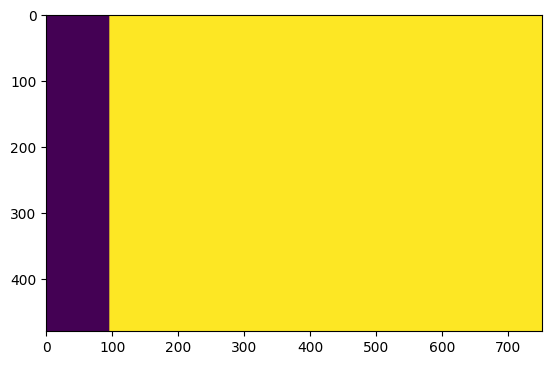

In [543]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [544]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

## Extracting and Matching Features
Now that we have a way to get our stereo depth estimations, we need to make some helper functions for detecting and matching features between two images. These functions are found below. We will mainly use David Lowe's [SIFT](https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf) in this tutorial, since it is a classic, robust approach that computes scale and rotation invariant feature descriptors. For more details, refer to the OpenCV [Introduction to SIFT](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html) article.

In [545]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [546]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [547]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [548]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Time to compute disparity map using StereoSGBM: 0:00:00.058754
Number of matches before filtering: 364
Number of matches after filtering: 254


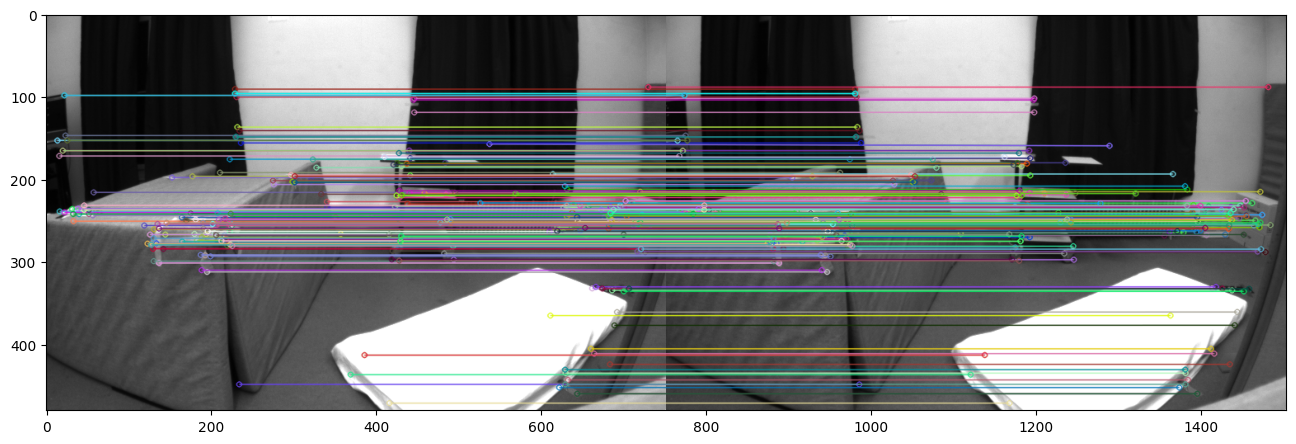

In [549]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM: 0:00:00.013689
Number of matches before filtering: 364
Number of matches after filtering: 254


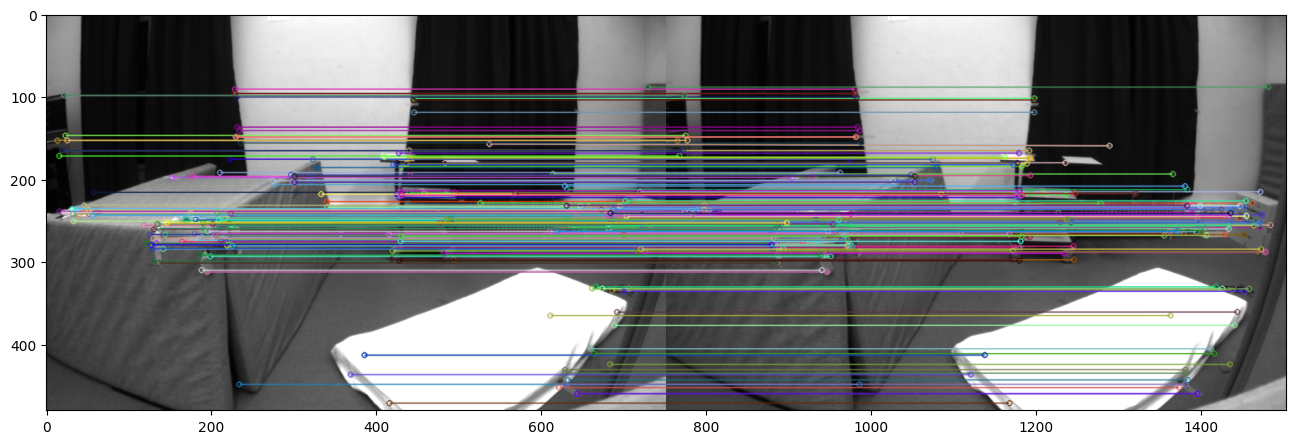

In [550]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [551]:
# We can see that the 'bm' matcher is around 5x faster than the 'sgbm' matcher, and produced the
# same number of matches. Since speed is essential, we will use the 'bm' matcher

Time to compute disparity map using StereoBM: 0:00:00.020801
Number of matches before filtering: 500
Number of matches after filtering: 449


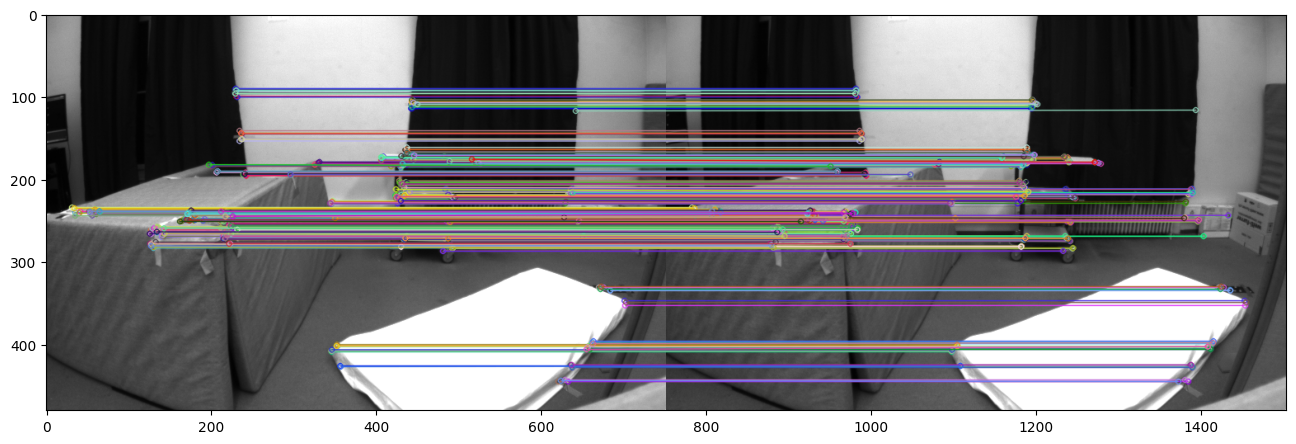

In [552]:
# Now to see the difference with ORB descriptor
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.8)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoSGBM: 0:00:00.032528


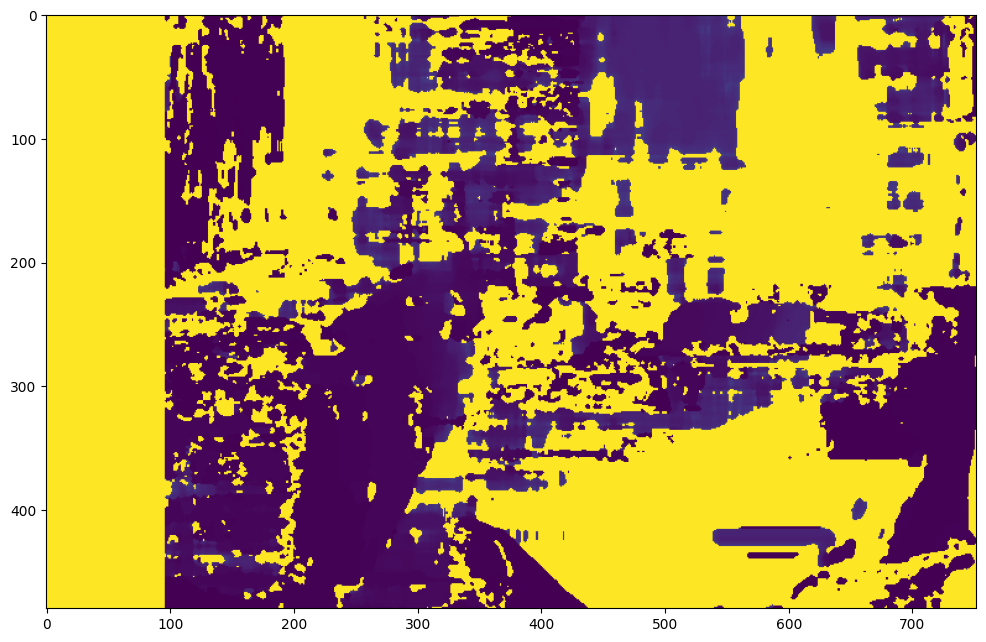

In [553]:
# Now a side-by-side comparison of the stereo depth vs lidar depth maps
depth_stereo = stereo_2_depth(image_left, 
                             image_right, 
                             handler.P0, 
                             handler.P1,
                             matcher='sgbm',
                             verbose=True)
#depth_lidar = pointcloud2image(handler.first_pointcloud, handler.imheight, handler.imwidth,
                               #handler.Tr, handler.P0
                              #)
fig, (ax1) = plt.subplots(1, 1, figsize=(12,8))
ax1.imshow(depth_stereo)
#ax2.imshow(depth_lidar)

In [554]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [555]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''

    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))

    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)

    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
    
        image_left = handler.images_left[i]
        image_right = handler.images_right[i]
        # Get next frame in the left camera for visual odometry
        image_plus1 = handler.images_left[i+1]
    
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)

        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

#### StereoBM disparity matching

In [556]:
# Let's see if using the FLANN matcher improves our frame rate at all
start = datetime.datetime.now()
#subset = 500
orb_trajectory = visual_odometry(handler, 
                                   filter_match_distance=0.3, 
                                    detector='orb',
                                    #detector='sift',
                                    #matching='FLANN',
                                    #stereo_matcher='sgbm',
                                    #stereo_matcher='bm',
                                   subset=subset)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with ORB and matching with BF
Filtering feature matches at threshold of 0.3*distance
Time to compute frame 1: 0:00:00.027402
Time to compute frame 2: 0:00:00.023300
Time to compute frame 3: 0:00:00.019591
Time to compute frame 4: 0:00:00.021430
Time to compute frame 5: 0:00:00.020076
Time to compute frame 6: 0:00:00.021884
Time to compute frame 7: 0:00:00.016160
Time to compute frame 8: 0:00:00.021938
Time to compute frame 9: 0:00:00.021594
Time to compute frame 10: 0:00:00.023394
Time to compute frame 11: 0:00:00.022706
Time to compute frame 12: 0:00:00.023506
Time to compute frame 13: 0:00:00.021420
Time to compute frame 14: 0:00:00.022456
Time to compute frame 15: 0:00:00.019120
Time to compute frame 16: 0:00:00.021719
Time to compute frame 17: 0:00:00.021960
Time to compute frame 18: 0:00:00.020983
Time to compute frame 19: 0:00:00.023217
Time to compute frame 20: 0:00:00.025005
Time to compute frame 21: 0:00:00.023873
Time to

In [557]:
# Let's see if using the FLANN matcher improves our frame rate at all
# start = datetime.datetime.now()
# sift_bm_trajectory = visual_odometry(handler,
#                                    filter_match_distance=0.5, 
#                                     #detector='orb',
#                                     detector='sift',
#                                     #matching='FLANN',
#                                     #stereo_matcher='sgbm',
#                                     stereo_matcher='bm',
#                                    subset=subset)
# end = datetime.datetime.now()
# print('Time to perform odometry:', end-start)

In [558]:
# Let's see if using the FLANN matcher improves our frame rate at all
# start = datetime.datetime.now()
# sift_sgbm_trajectory = visual_odometry(handler,
#                                    filter_match_distance=0.5, 
#                                     #detector='orb',
#                                     detector='sift',
#                                     #matching='FLANN',
#                                     stereo_matcher='sgbm',
#                                     #stereo_matcher='bm',
#                                    subset=subset)
# end = datetime.datetime.now()
# print('Time to perform odometry:', end-start)

In [559]:
# Let's see if using the FLANN matcher improves our frame rate at all
# start = datetime.datetime.now()
# flann_trajectory = visual_odometry(handler,
#                                    filter_match_distance=0.5, 
#                                     #detector='orb',
#                                     #detector='sift',
#                                     matching='FLANN',
#                                     #stereo_matcher='sgbm',
#                                     #stereo_matcher='bm',
#                                    subset=subset)
# end = datetime.datetime.now()
# print('Time to perform odometry:', end-start)

We can now compare the results of visual odometry against the ground truth provided.

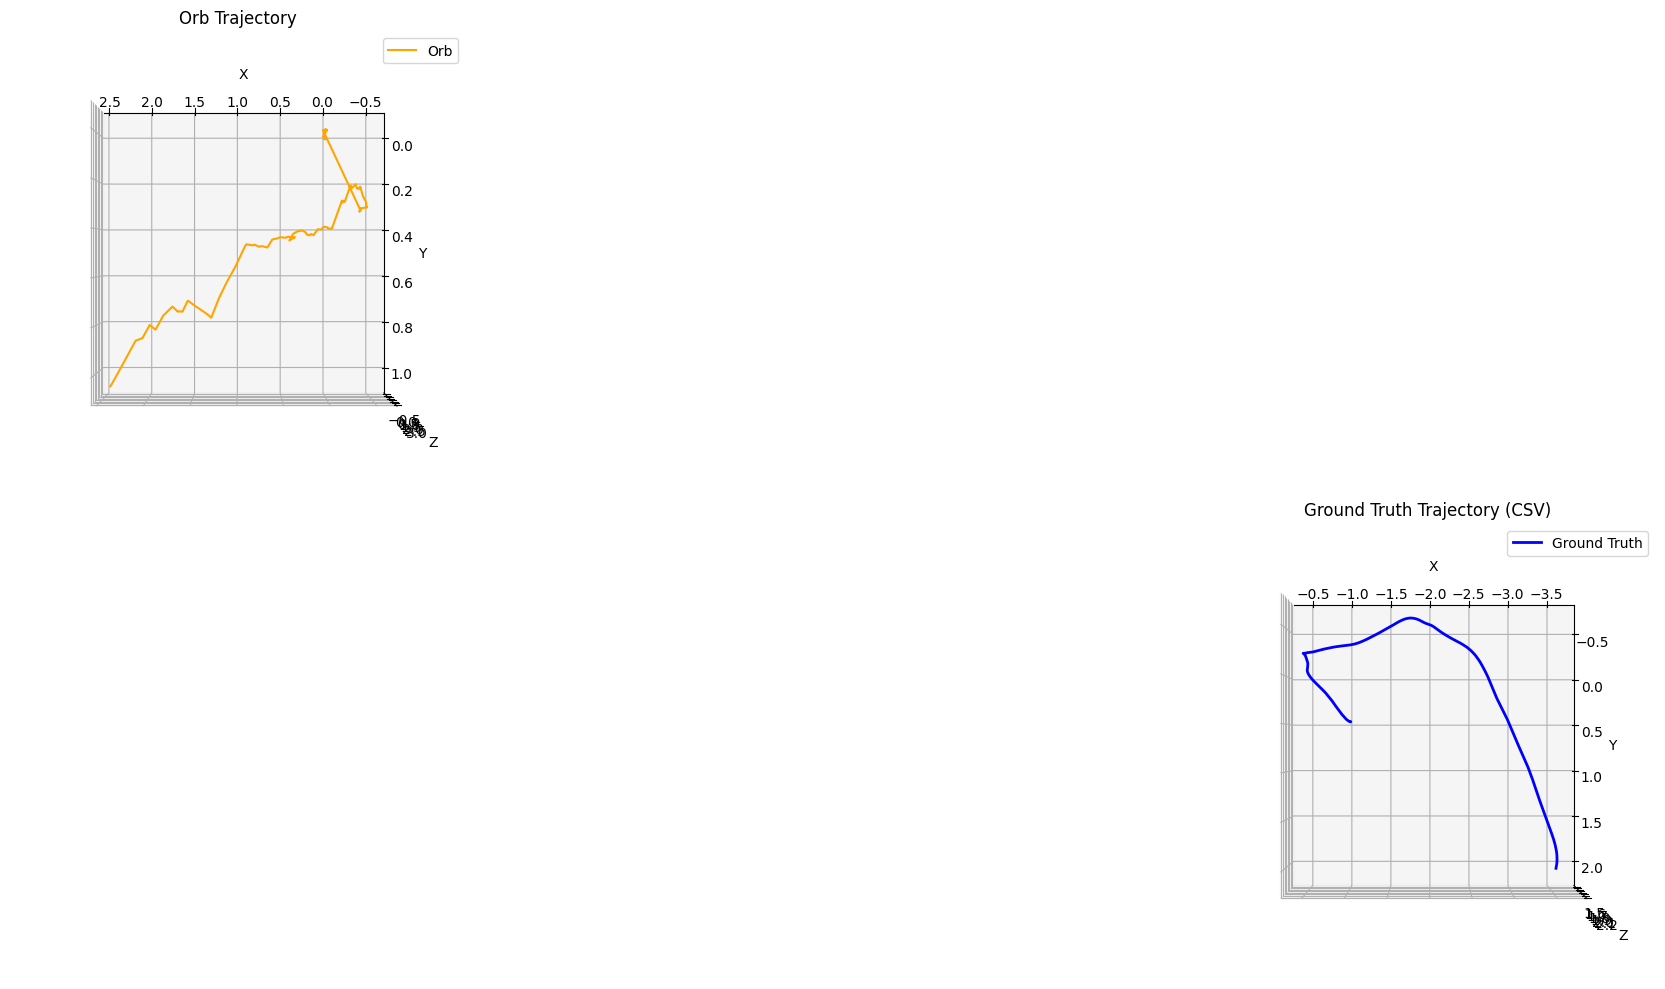

In [560]:
fig = plt.figure(figsize=(18, 10))  # Bigger figure for 2 rows

# 1st row
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.plot(orb_trajectory[:, :, 3][:, 0], 
         orb_trajectory[:, :, 3][:, 1], 
         orb_trajectory[:, :, 3][:, 2], 
         label='Orb', color='orange')
ax1.set_title('Orb Trajectory')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=90, azim=90)
ax1.legend()

# ax3 = fig.add_subplot(2, 3, 3, projection='3d')
# ax3.plot(sift_bm_trajectory[:, :, 3][:, 0], 
#          sift_bm_trajectory[:, :, 3][:, 1], 
#          sift_bm_trajectory[:, :, 3][:, 2], 
#          label='Sift_Bm', color='orange')
# ax3.set_title('Sift_Bm Trajectory')
# ax3.set_xlabel('X')
# ax3.set_ylabel('Y')
# ax3.set_zlabel('Z')
# ax3.view_init(elev=90, azim=90)
# ax3.legend()

# # 2nd row
# ax4 = fig.add_subplot(2, 3, 4, projection='3d')
# ax4.plot(sift_sgbm_trajectory[:, :, 3][:, 0], 
#          sift_sgbm_trajectory[:, :, 3][:, 1], 
#          sift_sgbm_trajectory[:, :, 3][:, 2], 
#          label='Sift_Sgbm', color='orange')
# ax4.set_title('Sift_Sgbm Trajectory')
# ax4.set_xlabel('X')
# ax4.set_ylabel('Y')
# ax4.set_zlabel('Z')
# ax4.view_init(elev=90, azim=90)
# ax4.legend()

# ax5 = fig.add_subplot(2, 3, 5, projection='3d')
# ax5.plot(flann_trajectory[:, :, 3][:, 0], 
#          flann_trajectory[:, :, 3][:, 1], 
#          flann_trajectory[:, :, 3][:, 2], 
#          label='Flann', color='orange')
# ax5.set_title('Flann Trajectory')
# ax5.set_xlabel('X')
# ax5.set_ylabel('Y')
# ax5.set_zlabel('Z')
# ax5.view_init(elev=90, azim=90)
# ax5.legend()

ax6 = fig.add_subplot(2, 3, 6, projection='3d')
ax6.plot(x, y, z, label='Ground Truth', linewidth=2, color='blue')
ax6.set_title('Ground Truth Trajectory (CSV)')
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_zlabel('Z')
ax6.view_init(elev=90, azim=90)
ax6.legend()

plt.tight_layout()
plt.show()


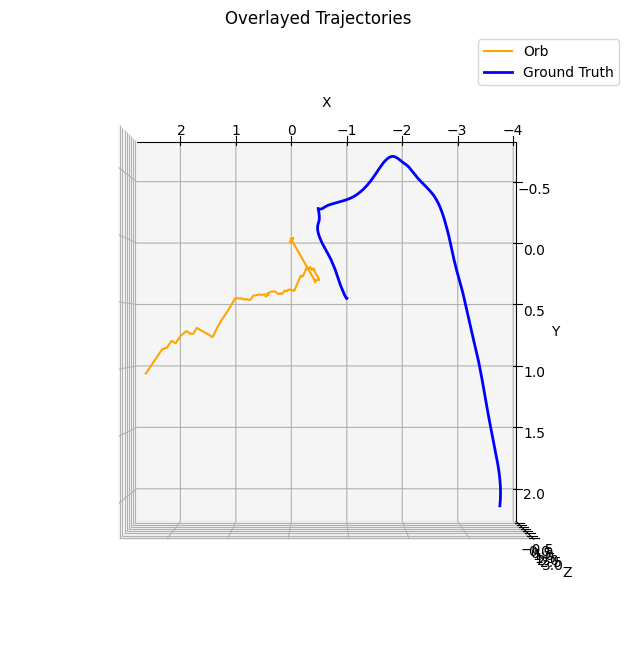

In [561]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Load CSV
df = pd.read_csv("/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/poses.csv")

# Extract first 'subset' rows for x, y, z
x = df['x'].iloc[:subset]
y = df['y'].iloc[:subset]
z = df['z'].iloc[:subset]


ax.plot(orb_trajectory[:, :, 3][:, 0], 
        orb_trajectory[:, :, 3][:, 1], 
        orb_trajectory[:, :, 3][:, 2], 
        label='Orb', color='orange')

# ax.plot(sift_trajectory[:, :, 3][:, 0], 
#         sift_trajectory[:, :, 3][:, 1], 
#         sift_trajectory[:, :, 3][:, 2], 
#         label='Sift', color='green')

# ax.plot(sift_bm_trajectory[:, :, 3][:, 0], 
#         sift_bm_trajectory[:, :, 3][:, 1], 
#         sift_bm_trajectory[:, :, 3][:, 2], 
#         label='Sift_Bm', color='red')

# ax.plot(sift_sgbm_trajectory[:, :, 3][:, 0], 
#         sift_sgbm_trajectory[:, :, 3][:, 1], 
#         sift_sgbm_trajectory[:, :, 3][:, 2], 
#         label='Sift_Sgbm', color='purple')

# ax.plot(flann_trajectory[:, :, 3][:, 0], 
#         flann_trajectory[:, :, 3][:, 1], 
#         flann_trajectory[:, :, 3][:, 2], 
#         label='Flann', color='brown')

ax.plot(x, y, z, label='Ground Truth', linewidth=2, color='blue')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Overlayed Trajectories')
ax.view_init(elev=90, azim=90)
ax.legend()

plt.show()


In [562]:
import plotly.graph_objects as go

fig = go.Figure()

# Load CSV
df = pd.read_csv("/home/ros_ws/noetic/DeepVO/datasets/vicon_firefly_sbx_cam0_easy_q_rpy/poses.csv")

# Extract first 'subset' rows for x, y, z
x = df['x'].iloc[:subset]
y = df['y'].iloc[:subset]
z = df['z'].iloc[:subset]

# Add Orb trajectory
fig.add_trace(go.Scatter3d(
    x=orb_trajectory[:, :, 3][:, 0],
    y=orb_trajectory[:, :, 3][:, 1],
    z=orb_trajectory[:, :, 3][:, 2],
    mode='lines',
    name='Orb',
    line=dict(color='orange')
))

# # Add Sift trajectory
# fig.add_trace(go.Scatter3d(
#     x=sift_trajectory[:, :, 3][:, 0],
#     y=sift_trajectory[:, :, 3][:, 1],
#     z=sift_trajectory[:, :, 3][:, 2],
#     mode='lines',
#     name='Sift',
#     line=dict(color='green')
# ))

# # Add Sift_Bm trajectory
# fig.add_trace(go.Scatter3d(
#     x=sift_bm_trajectory[:, :, 3][:, 0],
#     y=sift_bm_trajectory[:, :, 3][:, 1],
#     z=sift_bm_trajectory[:, :, 3][:, 2],
#     mode='lines',
#     name='Sift_Bm',
#     line=dict(color='red')
# ))

# # Add Sift_Sgbm trajectory
# fig.add_trace(go.Scatter3d(
#     x=sift_sgbm_trajectory[:, :, 3][:, 0],
#     y=sift_sgbm_trajectory[:, :, 3][:, 1],
#     z=sift_sgbm_trajectory[:, :, 3][:, 2],
#     mode='lines',
#     name='Sift_Sgbm',
#     line=dict(color='purple')
# ))

# # Add Flann trajectory
# fig.add_trace(go.Scatter3d(
#     x=flann_trajectory[:, :, 3][:, 0],
#     y=flann_trajectory[:, :, 3][:, 1],
#     z=flann_trajectory[:, :, 3][:, 2],
#     mode='lines',
#     name='Flann',
#     line=dict(color='brown')
# ))

# Add Ground Truth
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='lines',
    name='Ground Truth',
    line=dict(color='blue', width=4)
))

fig.update_layout(
    title='Overlayed Trajectories',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'  # Keep aspect ratio proportional
    ),
    legend=dict(x=0.7, y=0.9)
)


# Appendix A:
Showing that arithmetic strategy faster than dot product:

In [563]:
# Decompose projection matrix to get intrinsic k matrix
k0, r0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)

In [564]:
# First run the math using the arithmetric derived from what the matrix multiplication does
start = datetime.datetime.now()
cx = k0[0, 2]
cy = k0[1, 2]
fx = k0[0, 0]
fy = k0[1, 1]
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
        delete.append(i)
        continue
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    object_points = np.vstack([object_points, np.array([x, y, z])])
    #object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.006672
[[-5.52969675e+00 -2.15342029e-01  8.22339237e+00]
 [-4.29441408e-03  1.46750936e-04  1.39084862e-02]
 [-4.26029497e+00  2.25736874e-01  8.22339237e+00]
 ...
 [ 2.66723554e+00 -1.30912027e+00  8.22339237e+00]
 [ 6.88453253e-01  3.78127151e-01  1.09645233e+00]
 [ 6.51710302e-02 -4.18579473e-02  5.26297119e-01]]


In [565]:
# Now run the math using matrix multiplication with the inverted k matrix
start = datetime.datetime.now()
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
    #    print(z)
        delete.append(i)
        continue
    #else:
    #    print(u,v)
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    #object_points = np.vstack([object_points, np.array([x, y, z])])
    object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.026419
[[-5.52969675e+00 -2.15342029e-01  8.22339237e+00]
 [-4.29441408e-03  1.46750936e-04  1.39084862e-02]
 [-4.26029497e+00  2.25736874e-01  8.22339237e+00]
 ...
 [ 2.66723554e+00 -1.30912027e+00  8.22339237e+00]
 [ 6.88453253e-01  3.78127151e-01  1.09645233e+00]
 [ 6.51710302e-02 -4.18579473e-02  5.26297119e-01]]


In [566]:
# We can see that the arithmetic method is significantly faster